<!DOCTYPE html>
<html lang="fr">
<head>
    <meta charset="UTF-8">
    <title>Tracking de Particules avec Trackpy</title>
    <style>
        body {
            font-family: Arial, sans-serif;
        }
        h1 {
            color: skyblue;
            font-size: 24px;
        }
        p {
            font-size: 16px;
        }
    </style>
</head>
<body>
    <h1>Tracking de Particules avec Trackpy</h1>
    <p>Ce code est conçu pour effectuer le tracking de particules à partir de séquences d'images, notamment des mosaïques obtenues par microscopie. Nous utilisons pour cela la librairie Trackpy, spécialisée dans l'analyse de trajectoires de particules.</p>
    <p>Toutes les expériences contenues dans le dossier spécifié sont automatiquement analysées. Le processus consiste à :</p>
    <ol>
        <li><strong>Identification des particules :</strong> Détecter et enregistrer les données de toutes les particules visibles sur chaque image de la séquence.</li>
        <li><strong>Enregistrement des trajectoires :</strong> Compiler les mouvements des particules à travers les images pour former des trajectoires cohérentes, qui sont ensuite enregistrées dans un fichier dédié.</li>
    </ol>
    <p>Les fichiers générés comprennent des données détaillées sur les particules pour chaque frame et un second fichier contenant les trajectoires complètes. Ces données sont préparées pour être réanalysées et traitées plus en détail dans un second code.</p>
</body>
</html>


In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Aug 21 10:51:23 2023

@author: souchaud
"""

import os
import glob
import time
import imageio.v2 as imageio
import cv2
import gc  # Garbage Collector interface
import numpy as np
import pandas as pd
import trackpy as tp
from scipy import ndimage
from skimage import util
from tqdm import tqdm
# import functions_track_and_analyze as lib
import matplotlib.pyplot as plt
from IPython.display import display
# from joblib import Parallel, delayed

In [3]:
# Consolidated parameters
CONDITION = 'CytoOne_HL5_AMPC_10x'
PARAMS = {
        # Préparation images
        'GaussianBlur': (5, 5), # (19, 19), #  (5, 5),
        'sigmaX': 10,
        'sigmaY': 10, 
        'threshold': 1, # 3, # 10  # 40,
        'percentile': 10, #10,
        'lenght_study': 50, # Découpage de la manip en nombre de frale pour favoriser l'étude (performence ordi)
        'smoothing_size': None,
        'invert': False,
        'preprocess': True, 
        'characterize': True,
        'filter_before': None,
        'filter_after': None,
        # Paramètres Manip
        'pixel_size': 0.637,  # 1.2773, # en um
        'frame_interval': 15, # temps entre chaque frame [s]
        'long_time': False,
        'max_frame': 340, # 340, #340 # Nombre de frame d'étude max.
        'min_frames': 150, #150, # Nombre de frame sur laquelle doit être suivie une cellule
        'topn': 1500, # None, # Nombre de particules max à détecter

        # Détéction particules
        'diameter': 15,  # 15, # Diamètres évalué des particules
        'max_displacement': 30, # 35, # 25, # Déplacement maximal des cellules entre deux images (en pixel)
        'search_range': 30, #  30, #  20 # même chose
        'minmass': 500, #  Mass minimale mesurée des cellules
        'max_size': 30, # 25, # Taille maximum de la particule
        'separation': 20, # 9, # distance mimimanl pour séparé deux objets
        'noise_size': 3,  # 7, # 7, # taille des particules à exclure 
        'max_iterations': 15, # Nombre d'itérations max pour résoudre un sous-réseau (déterminer les trajectoires entre 2 cellules)
        'memory': 5, # Nombre de frame au dela de laquelle on oublie la cellule
        'engine': 'auto',

        # Format et chemins
        'remove_exts': ['.jpg', '.svg', 'hdf5', '.png'],   
        # 'data_dir': '/Users/souchaud/Desktop/A_Analyser/CytoOne_SorC_10x/',
        'data_dir': os.path.join('/Users/souchaud/Desktop/A_Analyser/',CONDITION),
        # 'data_dir': '/Volumes/Labo_Alex_Mac/A_analyser/CytoOne_HL5/',
        # 'data_dir': '/Users/souchaud/Desktop/A_Analyser/NonT_SorC/',
        # 'output_dir': '/Users/souchaud/Desktop/Analyses/CytoOne_HL5_longtime/'
        # 'data_dir': '/Volumes/Labo_Alex_Mac/A_analyser/CytoOne_HL5/',´
        # 'output_dir': '/Users/souchaud/Desktop/Analyses/CytoOne_SorC_10x_results_tracking/'
        'output_dir': os.path.join('/Users/souchaud/Desktop/Analyses/', CONDITION + '_results_tracking')
        # 'output_dir': '/Users/souchaud/Desktop/Analyses/NonT_SorC_longtime_New/'
        }

In [4]:
EXPERIMENT_NAMES = [f + '/mosaic/' for f in os.listdir(PARAMS['data_dir'])
                    if os.path.isdir(os.path.join(PARAMS['data_dir'], f))]
print(EXPERIMENT_NAMES)

['2025_02_27_ASMOT281_AX3_MAT_P3_10x_CytoOnne_HL5_0225-10h30-0227-14h30_SorC1000/mosaic/', '2025_02_27_ASMOT280_AX3_MAT_P3_10x_CytoOnne_HL5_0225-10h30-0227-13h00_SorC1000/mosaic/', '2025_02_27_ASMOT279_AX3_MAT_P3_10x_CytoOnne_HL5_0225-10h30-0227-10h30_SorC1000/mosaic/']


In [5]:
def compute_mean_speed(filtered):
    """
    Compute mean speed.

    Parameters
    ----------
    - filtered: DataFrame with tracked cells
    Returns
    - mean_speed: Mean speed of all particles
    - mean_speed_part: Mean speed per particle
    """
    dx = filtered.groupby('particle')['x'].diff()
    dy = filtered.groupby('particle')['y'].diff()
    displacement = np.sqrt(dx**2 + dy**2)
    duration = filtered.groupby('particle')['frame'].diff() * PARAMS['frame_interval']
    mean_speed = (displacement.sum() / duration.sum()) * PARAMS['pixel_size'] * 60
    instant_speed = displacement / duration
    mean_speed_part = instant_speed.groupby(filtered['particle']).mean() * PARAMS['pixel_size'] * 60
    return mean_speed, mean_speed_part


def clean_directory(dir_path):
    """Remove all files with the specified extensions in the directory."""
    for file in os.listdir(dir_path):
        if file.endswith(tuple(PARAMS['remove_exts'])):
            os.remove(os.path.join(dir_path, file))

In [6]:
def adjust_brightness_contrast(img, brightness=0, contrast=0):
    """ Ajuster la luminosité et le contraste d'une image """
    B = brightness / 100.0
    C = contrast / 100.0
    k = np.tan((45 + 44 * C) / 180 * np.pi)

    img = (img - 127.5 * (1 - B)) * k + 127.5 * (1 + B)
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img

In [7]:
def process_experiment(exp_name, PARAMS):
    """Process a single experiment."""
    output_path = os.path.join(PARAMS['output_dir'], exp_name)
    print("output_path : ", output_path)
    # Séparer la chaîne au premier "/"
    exp_name_solo = exp_name.split('/', 1)[0]
    print("exp name : ", exp_name)
    os.makedirs(output_path, exist_ok=True)

    clean_directory(output_path)

    experiment_data_dir = os.path.join(PARAMS['data_dir'], exp_name)

    def extract_number(filename):
        # Extrait le numéro à partir du nom de fichier
        base_name = os.path.basename(filename)
        # Supprime l'extension et extrait le numéro
        number = int(base_name.split('_')[-1].split('.')[0])
        return number

    tiff_files = sorted(glob.glob(os.path.join(experiment_data_dir, "*.tif")), key=extract_number)

    # Use PARAMS dictionary to get the parameters
    frame_data = []
    frame_counter = 0
    boucle = []
    if PARAMS['long_time'] is False:
        if len(os.listdir(experiment_data_dir)) < PARAMS['max_frame']:
            nbr_frame_study_total = len(os.listdir(experiment_data_dir))
        else:
            nbr_frame_study_total = PARAMS['max_frame']
    else:
        nbr_frame_study_total = len(os.listdir(experiment_data_dir))

    lenght_study = PARAMS['lenght_study']
    if nbr_frame_study_total > lenght_study:
        number = lenght_study
        while number < nbr_frame_study_total:
            boucle.append(lenght_study)
            number += lenght_study
            if number > nbr_frame_study_total:
                boucle.append(nbr_frame_study_total - len(boucle) * lenght_study)
        nbr_frame_study = lenght_study
    else:
        nbr_frame_study = nbr_frame_study_total
        boucle.append(nbr_frame_study)

    # Process each batch of frames
    frame_0 = None  # Initialize frame_0 with a default value
    for i in tqdm(boucle, desc="processing batches"):
        batch_frames = tiff_files[frame_counter:frame_counter + i]
        batch_data = [np.array(imageio.imread(tiff_file)) for tiff_file in batch_frames]
        time_count = time.time()

        for num, frame in enumerate(batch_data):
            # Prétraitement
            blurred = ndimage.median_filter(frame, size=8)
            blurred = cv2.GaussianBlur(blurred, PARAMS['GaussianBlur'], 0)
            # equalized = cv2.equalizeHist(blurred)
            frame = blurred
            batch_data[num] = frame

            if num == 0:
                if frame_counter == 0:
                    frame_0 = frame  # Ensure frame_0 is assigned here
                    
                plt.figure(figsize=(12, 6))
                plt.imshow(frame_0, cmap='gray')
                plt.show()
            
                f = tp.locate(frame,
                              diameter=PARAMS['diameter'],
                              minmass=PARAMS['minmass'],
                              maxsize=PARAMS['max_size'],
                              separation=PARAMS['separation'],
                              noise_size=PARAMS['noise_size'],
                              smoothing_size=PARAMS['smoothing_size'],
                              threshold=PARAMS['threshold'],
                              invert=PARAMS['invert'],
                              percentile=PARAMS['percentile'],
                              topn=PARAMS['topn'],
                              preprocess=PARAMS['preprocess'],
                              max_iterations=PARAMS['max_iterations'],
                              filter_before=PARAMS['filter_before'],
                              filter_after=PARAMS['filter_after'],
                              characterize=PARAMS['characterize'],
                              engine=PARAMS['engine'])
                print(len(f))

                transformed_image_path = os.path.join(output_path, f'transformed_frame_{i}.jpg')
                cv2.imwrite(transformed_image_path, frame)

                fig, ax = plt.subplots(figsize=(12, 6))
                tp.annotate(f, frame, ax=ax)
                display(fig)

                # Extract size information
                # The specific column name depends on your data; it might be 'size', 'mass', etc.
                sizes = f['size']

                # Plot the particle sizes
                # plt.figure(figsize=(12, 6))
                fig, ax = plt.subplots(figsize=(12, 6))
                plt.hist(sizes, bins=30)
                plt.xlabel('Particle size')
                plt.ylabel('Frequency')
                plt.title('Particle Size Distribution')
                plt.savefig(os.path.join(output_path, f'Hist_size_{i}.jpg'), format='jpg')  # Enregistrer avant de montrer
                # plt.show()
                display(fig)

                # plt.figure(figsize=(12,6))
                fig, ax = plt.subplots(figsize=(12, 6))
                tp.mass_size(f, ax=ax)  # Assurez-vous que 'f' est correctement configuré
                plt.savefig(os.path.join(output_path, f'mass_size_{i}.jpg'), format='jpg')
                # plt.show()
                # plt.close()  # Ferme la figure
                display(fig)
            del frame
        print("temps de travail sur les images : ", (time.time() - time_count)/60, "min")
        try:
            cells_loc = tp.batch(batch_data,
                                diameter= PARAMS['diameter'], #PARAMS['diameter'],
                                minmass=PARAMS['minmass']                                                                                                                                                                                                                                                                                                                                                                                                                                                 ,
                                maxsize=PARAMS['max_size'],
                                separation=PARAMS['separation'],
                                noise_size=PARAMS['noise_size'],
                                smoothing_size=PARAMS['smoothing_size'],
                                threshold=PARAMS['threshold'],
                                invert=PARAMS['invert'],
                                percentile=PARAMS['percentile'],
                                topn=PARAMS['topn'],
                                preprocess=PARAMS['preprocess'],
                                max_iterations=PARAMS['max_iterations'],
                                filter_before=PARAMS['filter_before'],
                                filter_after=PARAMS['filter_after'],
                                characterize=PARAMS['characterize'],
                                engine=PARAMS['engine'],
                                )
            display(cells_loc)
            cells_loc['frame'] += frame_counter
            frame_counter += i
            frame_data.append(cells_loc)
            del cells_loc
        except Exception as e:
            print(f"{exp_name} got an issue.")
            return
        
        try:
            del batch_data  # Tente de supprimer batch_data si elle existe
        except NameError:
            pass  # Ne fait rien si batch_data n'existe pas

        gc.collect()  # Force la collecte de déchets pour libérer de la mémoire


    all_features = pd.concat(frame_data)

    try:
        trajectories = tp.link_df(all_features,
                                  search_range=PARAMS['search_range'],  # PARAMS['max_displacement'],
                                  memory=PARAMS['memory'],
                                  neighbor_strategy='KDTree',
                                  link_strategy='auto',  # 'hybrid',
                                  adaptive_stop=30,
                                  # verify_integritxy=True,
                                  )
        trajectories.to_hdf(os.path.join(output_path, 'filtered.hdf5'), 'table')
        # verify_intetegrity=True)
        # neighbor_strategy='KDTree',
    except tp.SubnetOversizeException:
        print("Issue with this one")
        
    if trajectories.empty:
        print("oupsy oups")
        return
    filtered = tp.filter_stubs(trajectories, PARAMS['min_frames'])
    # filtered = filtered[~filtered.particle.isin(
    #     tp.filter_clusters(filtered, quantile=0.1,
    #                        threshold=filtered['size'].mean() * 1).index)]
    all_features.to_hdf(os.path.join(output_path, 'features.hdf5'), 'table')
    filtered.to_hdf(os.path.join(output_path, 'filtered.hdf5'), 'table')
    if not filtered.empty:
        if frame_0 is not None:
            fig, ax = plt.subplots(figsize=(10, 10))
            plt.title(f'Trajectories after suspicious particles {exp_name}')
            tp.plot_traj(filtered, ax=ax, superimpose=frame_0, label=False)
            plt.savefig(f'{output_path}/trajectories_{exp_name_solo}.png')  # Sauvegarder la figure
            plt.close(fig)  # Fermer la figure pour libérer la mémoire
    else:
        print(f"No trajectories to plot for {exp_name}.")
    gc.collect()  # Force la collecte de déchets pour libérer de la mémoire
    return filtered

Frame 339: 206 trajectories present.


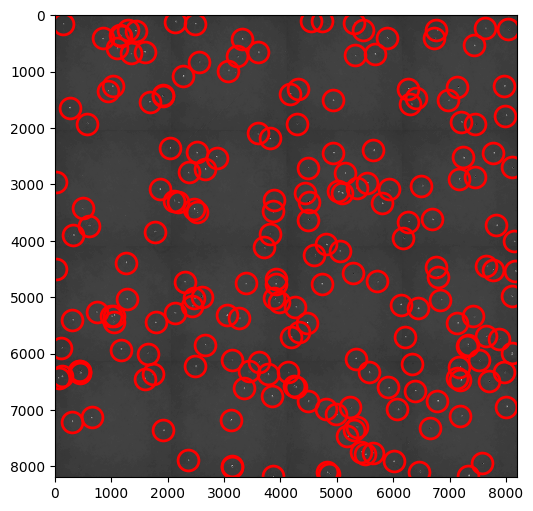

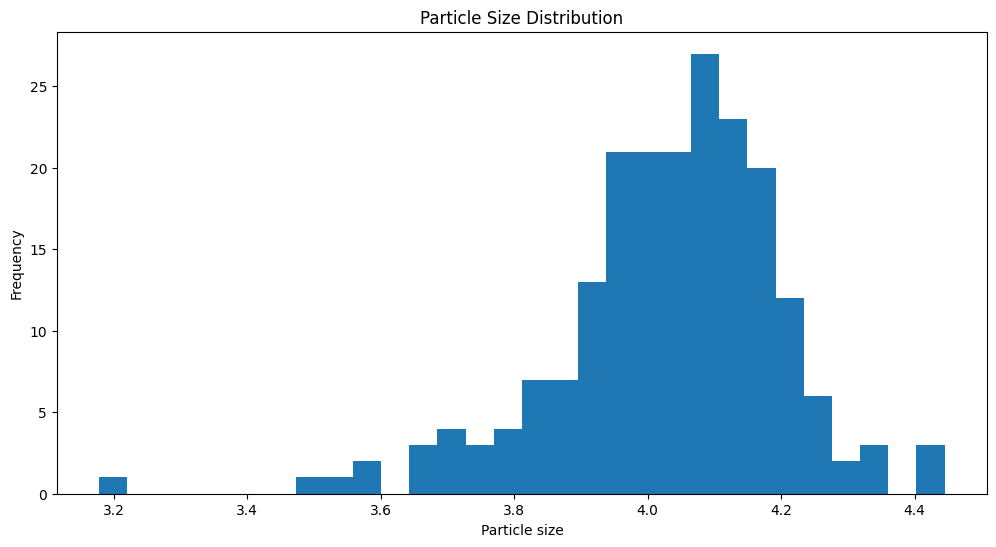

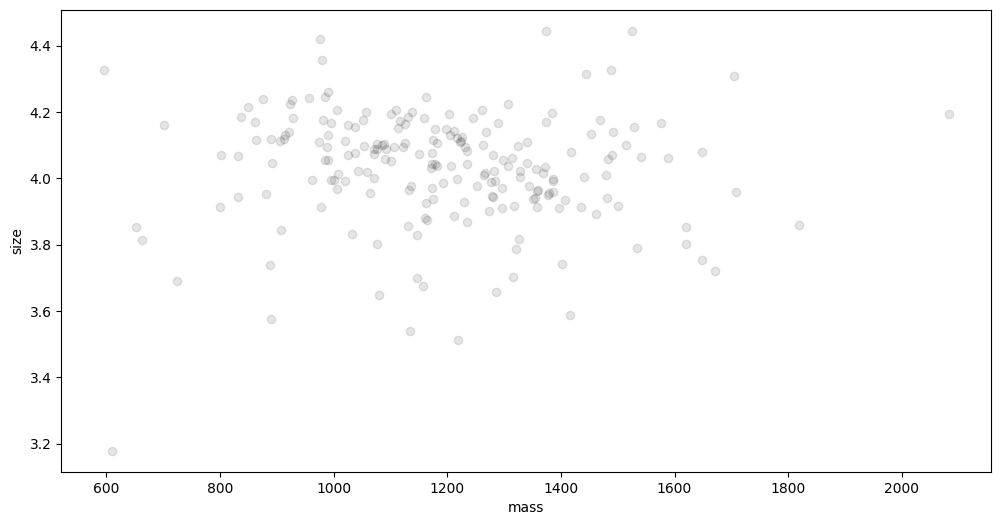

In [8]:
def main():
    """Process all experiments."""
    for exp_name in EXPERIMENT_NAMES:
        print(exp_name)
        process_experiment(exp_name, PARAMS)


if __name__ == '__main__':

    main()